In [170]:

import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
import time
import math


import torch as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from collections import deque, namedtuple

# from keras.models import Sequential
# from keras.layers import *
# from keras.optimizers import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import rc, animation
from IPython import display
from IPython.display import HTML
%matplotlib inline


In [171]:
class DQNmodel(nn.Module):
    def __init__(self,state_size,action_size,lr):
        super(DQNmodel, self).__init__()
        self.linear1 = nn.Linear(state_size,256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3V = nn.Linear(256, 1) 
        self.linear3A = nn.Linear(256,action_size)
        
        
        self.optimizer = optim.Adam(self.parameters(), lr)
        self.loss = nn.MSELoss()
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        state = T.Tensor(state).to(self.device)
        out = self.linear1(state)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        outV = self.linear3V(out)
        outA = self.linear3A(out)

        return outV,outA

In [172]:
class replay_buffer:
    def __init__(self,mem_size,state_size,action_size,mem_cntr):
        self.mem_size = mem_size
        self.state_memory = np.zeros((self.mem_size, *[state_size]), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *[state_size]), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)
        self.mem_cntr = mem_cntr
        self.action_size = action_size
        
    def storeTransition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1
        
    def get_sample(self,batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        state_batch = self.state_memory[batch]
        action_batch = self.action_memory[batch]
        reward_batch = self.reward_memory[batch]
        new_state_batch = self.new_state_memory[batch]
        terminal_batch = self.terminal_memory[batch]
        
        return state_batch,action_batch ,reward_batch,new_state_batch,terminal_batch

In [1]:
class DQNAgent(object):
    def __init__(self,state_size,action_size,lr,epsilon,batch_size,max_mem,mem_cntr):
        self.gamma = 0.99
        self.lr = lr
        self.epsilon = epsilon
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.model = DQNmodel(state_size,action_size,self.lr)
        self.model_target =  DQNmodel(state_size,action_size,self.lr)
        self.memory = replay_buffer(max_mem,state_size,action_size,mem_cntr)
        self.learn_step_counter = 0
        self.replace_target_cnt = 1000
        
    def get_action(self, observation):
        rand = np.random.random()
        _,actions = self.model.forward(observation)
        if rand > self.epsilon:
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_size)
        return action
    
    def replace_target_network(self):
        if self.replace_target_cnt is not None and \
           self.learn_step_counter % self.replace_target_cnt == 0:
            self.model_target.load_state_dict(self.model.state_dict())
    
    def learn(self):
        self.model.optimizer.zero_grad()
        self.replace_target_network()
        state_batch,action_batch, reward_batch,new_state_batch,terminal_batch = self.memory.get_sample(self.batch_size)
       
        state = T.tensor(state_batch).to(self.model.device)
        new_state = T.tensor(new_state_batch).to(self.model.device)
        action = T.tensor(action_batch).to(self.model.device)
        rewards = T.tensor(reward_batch).to(self.model.device)
        dones = T.tensor(terminal_batch).to(self.model.device)
        
        V_s, A_s = self.model.forward(state.float())
        V_s_, A_s_ = self.model_target.forward(new_state.float())
        q_pred = T.add(V_s, (A_s - A_s.mean(dim=1, keepdim=True))).gather(1,
                                              action.unsqueeze(-1)).squeeze(-1)

        q_next = T.add(V_s_, (A_s_ - A_s_.mean(dim=1, keepdim=True)))
        q_target = rewards + self.gamma*T.max(q_next, dim=1)[0].detach()
        q_target[dones] = 0.0

        loss = self.model.loss(q_target, q_pred).to(self.model.device)
        loss.backward()
        self.model.optimizer.step()
        self.learn_step_counter += 1
        
        
    def update_epsilon(self,number_of_episodes):
        self.epsilon = self.epsilon*(1-1/number_of_episodes)
        return self.epsilon
    
    

In [174]:
env = gym.make("CartPole-v1")
env.reset()
# plt.imshow(env.render('rgb_array'))

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [166]:
env = gym.make('LunarLander-v2')
env.reset()
# plt.imshow(env.render('rgb_array'))
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [ ]:
lr = 0.001
epsilon = 1
batch_size = 64
max_mem = 10000
mem_cntr = 0
count = 0
num_episodes = 1000
episode_rewards = []

agent = DQNAgent(state_size,action_size,lr,epsilon,batch_size,max_mem,mem_cntr)

for episode in range(num_episodes):
    done = False
    state = env.reset()
    total_reward = 0
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action) 
        agent.memory.storeTransition(state, action, reward,next_state,done)
        state = next_state
        total_reward += reward

        if count > batch_size:
            agent.learn()
            agent.update_epsilon(num_episodes)
        count = count + 1
        
        if done: 
            break
    
    episode_rewards.append(total_reward)
    
    if episode % 100 == 0:
        
        print('Episode {}'.format(episode))
        print('Last Episode Reward: {}'.format(total_reward))
        print('-'*10)

Episode 0
Last Episode Reward: 22.0
----------


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


Episode 100
Last Episode Reward: 9.0
----------
Episode 200
Last Episode Reward: 25.0
----------
Episode 300
Last Episode Reward: 141.0
----------
Episode 400
Last Episode Reward: 403.0
----------


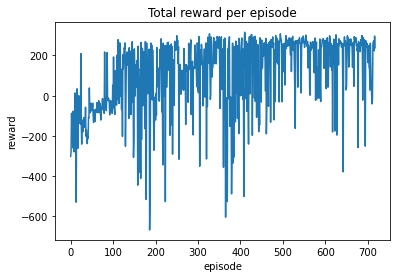

In [168]:
plt.plot(episode_rewards)
plt.title("Total reward per episode")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

In [169]:
np.save('DQN_LunarLander',episode_rewards)